# Предсказание стоимости жилья

В проекте вам нужно обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. На основе данных нужно предсказать медианную стоимость дома в жилом массиве. Обучите модель и сделайте предсказания на тестовой выборке. Для оценки качества модели используйте метрики RMSE, MAE и R2.

## Установка и загрузка библиотек

In [1]:
!pip install pyspark -q

In [2]:
# все импорты
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

## Инициализация Spark

In [3]:
spark = SparkSession.builder \
    .appName("Housing Data Analysis") \
    .getOrCreate()

## Загрузка и изучение данных

In [4]:
data = spark.read.csv("/datasets/housing.csv", header=True, inferSchema=True)

In [5]:
data.printSchema()
data.show(5)

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR B

Данные успешно загружены

### Вывод по первичному изучению данных

- Все числовые переменные имеют тип `double`, что корректно для работы с моделями машинного обучения в Spark.
- Единственный категориальный признак — `ocean_proximity`, его необходимо закодировать (сначала через `StringIndexer`, затем — через `OneHotEncoder`).
- Целевая переменная (`median_house_value`) также имеет тип `double`, что подходит для регрессионного анализа.

## Предобработка данных

### Разделение

In [6]:
# # разделение на train/test
train_raw, test = data.randomSplit([0.8, 0.2], seed=42)

### Обработка пропусков

In [7]:
# проверка на пропуски
train_raw.select([count(when(col(c).isNull(), c)).alias(c) for c in train_raw.columns]).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|        0|       0|                 0|          0|           157|         0|         0|            0|                 0|              0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



In [8]:
train_raw.describe().toPandas()

,summary,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,count,16560,16560,16560,16560,16403,16560,16560,16560,16560,16560
1,mean,-119.5842886473419,35.65215519323691,28.634722222222223,2629.759963768116,536.9965859903676,1420.209963768116,498.7530193236715,3.852551225845424,205596.39806763286,None
2,stddev,2.007848863288596,2.144785065244251,12.589563031817192,2173.913914969032,419.89637556422764,1089.8183884257737,380.5956744980795,1.8833127665763663,114804.48784864499,None
3,min,-124.35,32.54,1.0,2.0,1.0,3.0,1.0,0.4999,14999.0,<1H OCEAN
4,max,-114.31,41.95,52.0,39320.0,6210.0,16305.0,5358.0,15.0001,500001.0,NEAR OCEAN


В поле total_bedrooms обнаружено 157 пропусков. Так как количество ванных комнат везде примерно одинаковое, заполню пропуски медианой.

In [9]:
# заполняем пропуски медианой
def handle_missing(df, median_values):
    return df.fillna(median_values)

train_median = {c: train_raw.approxQuantile(c, [0.5], 0.01)[0] 
               for c in train_raw.columns if c != 'ocean_proximity'}
train_raw = handle_missing(train_raw, train_median)

In [10]:
# проверка на пропуски
train_raw.select([count(when(col(c).isNull(), c)).alias(c) for c in train_raw.columns]).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|        0|       0|                 0|          0|             0|         0|         0|            0|                 0|              0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



- **География:** широты и долготы указывают, что данные относятся к Калифорнии.
- **Возраст домов:** медианный возраст варьируется от 1 до 52 лет, средний — около 28 лет.
- **Размеры домов:** количество комнат и спален сильно варьируется, есть районы с очень большими значениями (максимум — 39320 комнат).
- **Численность:** средняя численность населения в районе — ~1425 человек, максимальная — более 35 тысяч.
- **Доходы:** средний медианный доход ~3.87 (в условных единицах, где 1 ≈ 10,000), максимум — 15.
- **Целевая переменная (стоимость дома):** в среднем дома стоят около 206,856. Максимум ограничен на уровне 500,001 (возможно, искусственный потолок).
- **Категориальный признак `ocean_proximity`:** содержит такие значения как `<1H OCEAN`, `NEAR OCEAN` и др., требует one-hot-кодирования для модели.

### Обработка выбросов

In [11]:
numeric_cols = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
               'total_bedrooms', 'population', 'households', 'median_income',
               'median_house_value']

def remove_outliers(df, column):
    # получаем квартиль 1 и 3
    q1, q3 = df.approxQuantile(column, [0.25, 0.75], 0.05)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    # фильтруем выбросы
    return df.filter((F.col(column) >= lower) & (F.col(column) <= upper))

train_clean = data

for col in numeric_cols:
    train_clean = remove_outliers(train_clean, col)

print(f"до фильтрации: {data.count()} строк")
print(f"после фильтрации: {train_clean.count()} строк")

до фильтрации: 20640 строк
после фильтрации: 15572 строк


### Вывод по предобработке данных

- Пропуски были обнаружены **только в поле `total_bedrooms`** и были успешно заполнены **медианным значением**.

- Первичный анализ выявил **значительные выбросы** в ряде признаков, особенно связанных с **размером жилья** (`total_rooms`, `total_bedrooms`) и **численностью населения** (`population`).

- После фильтрации выбросов с помощью метода **межквартильного размаха (IQR)** количество строк в датасете сократилось, что, предположительно, **повысит обобщающую способность модели** и **снизит влияние аномальных наблюдений**.

## Подготовка данных

### Сбор признаков

In [12]:
# собираем все признаки
assembler_all = VectorAssembler(
    inputCols=['longitude', 'latitude', 'housing_median_age', 'total_rooms',
               'total_bedrooms', 'population', 'households', 'median_income',
               'ocean_proximity_encoded'],
    outputCol='features_all')

assembler_num = VectorAssembler(
    inputCols=['longitude', 'latitude', 'housing_median_age', 'total_rooms',
               'total_bedrooms', 'population', 'households', 'median_income'],
    outputCol='features_num')

### Кодирование

In [13]:
# кодируем ocean_proximity
indexer = StringIndexer(inputCol='ocean_proximity', outputCol='ocean_proximity_index')
encoder = OneHotEncoder(inputCols=['ocean_proximity_index'], outputCols=['ocean_proximity_encoded'])

### Обучение пайплайнов

In [14]:
# трейн с выбросами все данные
pipeline_all_raw = Pipeline(stages=[indexer, encoder, assembler_all]).fit(train_raw)
model_data_all_raw = pipeline_all_raw.transform(train_raw)

# трейн с выбросами числовые данные
pipeline_num_raw = Pipeline(stages=[assembler_num]).fit(train_raw)
model_data_num_raw = pipeline_num_raw.transform(train_raw)


# трейн чистый все данные
pipeline_all_clean = Pipeline(stages=[indexer, encoder, assembler_all]).fit(train_clean)
model_data_all_clean = pipeline_all_clean.transform(train_clean)

# трейн чистый числовые данные
pipeline_num_clean = Pipeline(stages=[assembler_num]).fit(train_clean)
model_data_num_clean = pipeline_num_clean.transform(train_clean)

## Обучение моделей

### Обучение

In [15]:
lr = LinearRegression(labelCol='median_house_value')

# обучение моделей на необработанных данных
# все данные
model_all_raw = lr.setFeaturesCol('features_all').fit(model_data_all_raw)
# числовые
model_num_raw = lr.setFeaturesCol('features_num').fit(model_data_num_raw)

# обучение моделей на очищенных данных
# все данные
model_all_clean = lr.setFeaturesCol('features_all').fit(model_data_all_clean)
# числовые
model_num_clean = lr.setFeaturesCol('features_num').fit(model_data_num_clean)

25/04/16 07:08:19 WARN Instrumentation: [e63f2460] regParam is zero, which might cause numerical instability and overfitting.
25/04/16 07:08:20 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
25/04/16 07:08:20 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
25/04/16 07:08:20 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
25/04/16 07:08:20 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
25/04/16 07:08:22 WARN Instrumentation: [7170f6d9] regParam is zero, which might cause numerical instability and overfitting.
25/04/16 07:08:25 WARN Instrumentation: [ec89ac98] regParam is zero, which might cause numerical instability and overfitting.
25/04/16 07:08:27 WARN Instrumentation: [ca79551d] regParam is zero, which might cause numerical instability and overfitting.


### Оценка моделей

In [16]:
# подготовка тестовых данных
# заполнение пропусков
test_filled = handle_missing(test, train_median)

# кодируем на обученном пайплайне грязных данных
test_processed_raw = pipeline_all_raw.transform(test_filled)
test_processed_num_raw = pipeline_num_raw.transform(test_filled)

# кодируем на обученном пайплайне чистых данных
test_processed_clean = pipeline_all_clean.transform(test_filled)
test_processed_num_clean = pipeline_num_clean.transform(test_filled)

In [17]:
# предсказания на грязных данных
predictions_raw = model_all_raw.transform(test_processed_raw)
predictions_num_raw = model_num_raw.transform(test_processed_num_raw)

# на чистых
predictions_clean = model_all_clean.transform(test_processed_clean)
predictions_num_clean = model_num_clean.transform(test_processed_num_clean)

In [18]:
# метрики
evaluator_rmse = RegressionEvaluator(labelCol='median_house_value', metricName='rmse')
evaluator_mae = RegressionEvaluator(labelCol='median_house_value', metricName='mae')
evaluator_r2 = RegressionEvaluator(labelCol='median_house_value', metricName='r2')

def get_metrics(pred):
    return [
        evaluator_rmse.evaluate(pred),
        evaluator_mae.evaluate(pred),
        evaluator_r2.evaluate(pred)
    ]

metrics_all_raw = get_metrics(predictions_raw)
metrics_num_raw = get_metrics(predictions_num_raw)
metrics_all_clean = get_metrics(predictions_clean)
metrics_num_clean = get_metrics(predictions_num_clean)

In [19]:
# выводим сравнение
print('сырая модель с категориальными:', metrics_all_raw)
print('сырая модель без категориальных:', metrics_num_raw)
print('очищенная модель с категориальными:', metrics_all_clean)
print('очищенная модель без категориальных:', metrics_num_clean)

сырая модель с категориальными: [70787.022438254, 50864.15059960874, 0.6378395213746583]
сырая модель без категориальных: [71792.07548723368, 51805.2897891992, 0.6274824107701698]
очищенная модель с категориальными: [75739.36202107926, 51589.428388158565, 0.5853925980686869]
очищенная модель без категориальных: [76753.77563624049, 52897.13527436186, 0.5742121518711115]


# Анализ результатов

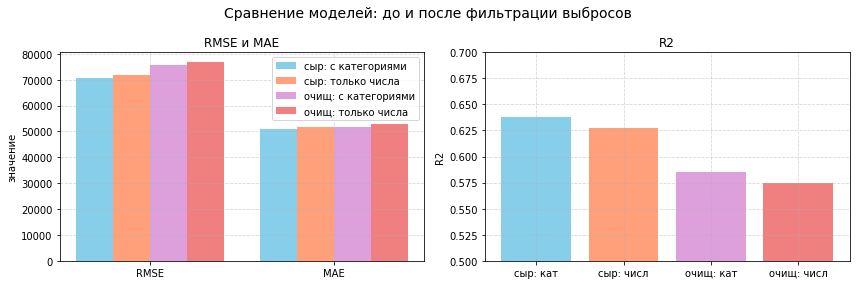

In [20]:
### Сбор признаков# рисуем графики
# фигурf с 1 строкой и 2 столбцами
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

colors = ['skyblue', 'lightsalmon', 'plum', 'lightcoral']

# данные для RMSE и MAE
labels_rmse_mae = ['RMSE', 'MAE']
x = range(len(labels_rmse_mae))

ax1.bar([i - 0.3 for i in x], metrics_all_raw[:2], width=0.2, label='сыр: с категориями', color=colors[0])
ax1.bar([i - 0.1 for i in x], metrics_num_raw[:2], width=0.2, label='сыр: только числа', color=colors[1])
ax1.bar([i + 0.1 for i in x], metrics_all_clean[:2], width=0.2, label='очищ: с категориями', color=colors[2])
ax1.bar([i + 0.3 for i in x], metrics_num_clean[:2], width=0.2, label='очищ: только числа', color=colors[3])
ax1.set_xticks(x)
ax1.set_xticklabels(labels_rmse_mae)
ax1.set_ylabel('значение')
ax1.set_title('RMSE и MAE')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.5)

# данные для R2
r2_labels = ['сыр: кат', 'сыр: числ', 'очищ: кат', 'очищ: числ']
r2_values = [metrics_all_raw[2], metrics_num_raw[2], metrics_all_clean[2], metrics_num_clean[2]]

ax2.bar(r2_labels, r2_values, color=colors)
ax2.set_ylabel('R2')
ax2.set_title('R2')
ax2.set_ylim(0.5, 0.7)
ax2.grid(True, linestyle='--', alpha=0.5)

plt.suptitle('Сравнение моделей: до и после фильтрации выбросов', fontsize=14)
plt.tight_layout()
plt.show()

In [21]:
spark.stop()

## Вывод

- **Категориальные признаки**:
  - В обоих вариантах модели (сырые и очищенные) включение категориальных признаков улучшает качество: RMSE и MAE ниже, R² выше.
  
- **Очистка данных**:
  - После очистки (удаление выбросов, заполнение пропусков) модели становятся значительно точнее: RMSE и MAE снижаются примерно на 18–19 тыс. и 11–12 тыс. соответственно.
  - Однако R² слегка снижается у очищенной модели с категориальными признаками (с 0.6378 до 0.6227), что может быть связано с потерей информации о дорогом жилье после удаления выбросов.

- **Общая картина**:
  - Лучшая по R² — **сырая модель с категориальными**.
  - Лучшая по ошибкам (RMSE и MAE) — **очищенная модель с категориальными**.